Introduction
============

This is interactive work-sheet regarding "Introduction to path planning" for the course "Innovative Programmiermethoden für Industrieroboter". (Author: Björn Hein)

License is based on Creative Commons: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) (pls. check: http://creativecommons.org/licenses/by-nc/4.0/)

This work-sheet conatains a second draft version to implement the A\* algorithm for path planning applications in Python. But this time based on **networkX**.

**Attention**: This worksheet has external dependencies 

* to the files "InnoKonz2dEnv.py" or "InnoKonzShapelyEnv.py". These files contain simple 2D environments based on numpy arrays or the shapely library with an interface for the use as collision checking in the algorithms.
* to the file "PlanerBasics.py", which contains the BaseClass for all planning algorithms 

Important links are:

* General Info: http://www.python.org
* Python tutorial http://www.python.org/doc/tut/
* NetworkX http://networkx.github.io/
* NumPy and SciPy Guide http://docs.scipy.org/
* Matplotlib gallery http://matplotlib.sourceforge.net/gallery.html


Remember that:

* you have to press ctrl-return or shift-return, to execute the code in the code sections, only then the variables are "generated" and can be used
* you can execute the whole notebook by Cell->runAll

In [1]:
import sys
sys.path.append("templates")

#reload modules if changed externally e.g. InnoKonz2DEnv.
#%load_ext autoreload 
#%autoreload 2

Calculating hash value for nodes needed for the close-list
====================================

As the close-list of the $A^*$ is typically implemented via a *hash-map* and therefore an appropriate hash-function has to be provided to identify the nodes. A suitable way are a key based on the coordinates of the nodes, as there are unique.

In [2]:
def getNodeID(pos):
    """Compute a unique identifier based on the position"""
    nodeId = "-"
    for i in pos:
        nodeId += str(i)+"-"
    return nodeId

In [3]:
a = dict()
a[getNodeID([20,20])] = 99
a[getNodeID([31,30])] = 101

print(a[getNodeID([31,30])], getNodeID([31,30]))
print(a[getNodeID([20,20])])


101 -31-30-
99


Implementing an A* for path planning
====================================

In the following there is an example for programming an A*-like path planning algorithm with some modifications. Please check Slides "AStar-Basics.pdf".

*Remark: handleNode and expandNode are in this example merged to one function*

Algorithm
---------

Info

* Function \__funame\__ identifies standard internal python function (e.g. \__init\__ -> Constructor)
* Function _funame indicates a private function (this is just a naming convention, there is now access control to this function)

In [4]:
import copy
import networkx as nx
import heapq
import math
from scipy.spatial.distance import euclidean, cityblock
from IPPlanerBase import PlanerBase

In [62]:
class AStar(PlanerBase):
    def __init__(self, collChecker=0):
        """Contructor:

        Initialize all necessary members"""

        super(AStar, self).__init__(collChecker)
        self.graph = nx.DiGraph()  # = CloseList
        self.openList = []  # (<value>, <node>)

        self.goal = []
        self.goalFound = False

        self.limits = self._collisionChecker.getEnvironmentLimits()

        self.w = 0.5
        return

    def _getNodeID(self, pos):
        """Compute a unique identifier based on the position"""

        nodeId = "-"
        for i in pos:
            nodeId += str(i)+"-"
        return nodeId

    def planPath(self, startList, goalList, config):
        """

        Args:
            start (array): start position in planning space
            goal (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options

        Example:

            config["w"] = 0.5
            config["heuristic"] = "euclid"

        """
        # 0. reset
        self.graph.clear()

        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(
            startList, goalList)

        # 2.
        self.w = config["w"]
        self.heuristic = config["heuristic"]
        self.dis = config['dis']
        self.digit = config['digit']
        self.goal = checkedGoalList[0]
        self._addGraphNode(checkedStartList[0])

        currentBestName = self._getBestNodeName()
        print('currenBestName' + currentBestName)
        breakNumber = 0
        while currentBestName:
            if breakNumber > 1000/(self.dis*self.dis):  # deskratesierung paramter
                break

            breakNumber += 1

            currentBest = self.graph.nodes[currentBestName]
            # print('currenBest:', currentBest)

            if currentBest["pos"] == self.goal:
                self.solutionPath = []
                self._collectPath(currentBestName, self.solutionPath)
                self.goalFound = True
                break

            currentBest["status"] = 'closed'
            print('currentBest["pos"]: ', currentBest["pos"])
            if self._collisionChecker.pointInCollision(currentBest["pos"]):
                currentBest['collision'] = 1
                currentBestName = self._getBestNodeName()
                # print(currentBestName)
                continue

            self.graph.nodes[currentBestName]['collision'] = 0

            # handleNode merges with former expandNode
            self._handleNode(currentBestName, self.dis , self.digit)
            currentBestName = self._getBestNodeName()

        if self.goalFound:
            return self.solutionPath
        else:
            return None

    def _insertNodeNameInOpenList(self, nodeName):
        """Get an existing node stored in graph and put it in the OpenList"""
        heapq.heappush(self.openList, (self._evaluateNode(nodeName), nodeName))

    def _addGraphNode(self, pos, fatherName=None):
        """Add a node based on the position into the graph. Attention: Existing node is overwritten!"""
        self.graph.add_node(self._getNodeID(pos), pos=pos, status='open', g=0)

        if fatherName != None:
            self.graph.add_edge(self._getNodeID(pos), fatherName)
            self.graph.nodes[self._getNodeID(
                pos)]["g"] = self.graph.nodes[fatherName]["g"] + 1

        self._insertNodeNameInOpenList(self._getNodeID(pos))

    def _setLimits(self, lowLimit, highLimit):
        """ Sets the limits of the investigated search space """
        assert (len(lowLimit) == len(highLimit) == self.dim)
        self.limits = list()
        for i in range(self.dim):
            self.limits.append([lowLimit[i], highLimit[i]])
        return

    def _getBestNodeName(self):
        """ Returns the best name of best node """
        return heapq.heappop(self.openList)[1]

    def _handleNode(self, nodeName, dis , digit):
        """Generats possible successor positions in all dimensions"""
        result = []
        node = self.graph.nodes[nodeName]
        print('node', node)
        for i in range(len(node["pos"])):
            print('first loop ', i)
            for u in [- dis, dis]:
                newPos = copy.copy(node["pos"])
                newPos[i] += u
                newPos[i] = round(newPos[i] , digit)

                print('u: ', u, 'newPos[i]: ', newPos[i])
                if not self._inLimits(newPos):
                    continue
                try:
                    # Do not do reopening! If node already in graph do not add it... Concequences?
                    self.graph.nodes[self._getNodeID(newPos)]
                    continue
                except:
                    pass

                self._addGraphNode(newPos, nodeName)
                print('newPos: ', newPos, 'nodeName: ', nodeName)
            print('END \n\n')
        return result

    def _computeHeuristicValue(self, nodeName):
        """ Computes Heuristic Value: Manhattan Distance """

        result = 0
        node = self.graph.nodes[nodeName]
        if self.heuristic == "euclidean":
            return euclidean(self.goal, node["pos"])
        else:
            return cityblock(self.goal, node["pos"])

    def _evaluateNode(self, nodeName):
        node = self.graph.nodes[nodeName]
        return self.w * self._computeHeuristicValue(nodeName) + (1 - self.w) * node["g"]

    def _collectPath(self, nodeName, solutionPath):

        fathers = list(self.graph.successors(nodeName))
        # print len(fathers)
        if len(fathers) == 1:
            self._collectPath(fathers[0], solutionPath)
        elif len(fathers) == 0:
            solutionPath.append(nodeName)
            return
        else:
            raise Exception(
                "not suitable numbers of fathers = {}.... please check".format(len(fathers)))
        solutionPath.append(nodeName)
        return

    def _inLimits(self, pos):
        result = True
        for i, limit in enumerate(self.limits):
            if pos[i] < limit[0] or pos[i] > limit[1]:
                result = False
                break
        return result


In [6]:
def aStarVisualize(planner, solution, ax = None, nodeSize = 300):
    graph = planner.graph
    collChecker = planner._collisionChecker
    # get a list of positions of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    color = nx.get_node_attributes(graph,'color')
    
    # get a list of degrees of all nodes
    #degree = nx.degree_centrality(graph)
    
    # draw graph (nodes colorized by degree)
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="open"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#FFFFFF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    draw_nodes.set_edgecolor("b")
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="closed"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#0000FF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    #nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    nx.draw_networkx_edges(graph,pos,
                               edge_color='b',
                               width=3.0
                            )
    
    collChecker.drawObstacles(ax)
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=nodeSize,
                             node_color='g')
        
    # draw edges based on solution path
    nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,arrows=True)
 
    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[0]],
                           node_size=300,
                           node_color='#00dd00',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[0]: "S"},  ax = ax)


    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[-1]],
                                   node_size=300,
                                   node_color='#DD0000',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[-1]: "G"},  ax = ax)


Questions:

* What could be useful to be checked in function setStartGoal besides start and goal having the same dimension?
* What is missing for a correct implementation of the A*? 
  * Why does this version not necessarily find the best solution? 
  * Why is it nevertheless useful to do so?



Set up planner
--------------

### Do the planning

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker

# Definition of a testing environment
trapField = dict()
trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1)

environment = CollisionChecker(trapField)


start = [[10,20]]
goal  = [[4, 2]]

# AStar
astar = AStar(environment)

# To know what is part on the config please consult the documentation of planPath
astarConfig = dict()
astarConfig["w"] = .5
astarConfig["heuristic"]  = "euclidean"
astarConfig["dis"]  = 2
astarConfig["digit"]  = 0


solution = astar.planPath(start, goal, astarConfig)
print(astar.graph)


currenBestName-10-20-
currentBest["pos"]:  [10, 20]
node {'pos': [10, 20], 'status': 'closed', 'g': 0, 'collision': 0}
first loop  0
u:  -2 newPos[i]:  8
newPos:  [8, 20] nodeName:  -10-20-
u:  2 newPos[i]:  12
newPos:  [12, 20] nodeName:  -10-20-
END 


first loop  1
u:  -2 newPos[i]:  18
newPos:  [10, 18] nodeName:  -10-20-
u:  2 newPos[i]:  22
newPos:  [10, 22] nodeName:  -10-20-
END 


currentBest["pos"]:  [10, 18]
node {'pos': [10, 18], 'status': 'closed', 'g': 1, 'collision': 0}
first loop  0
u:  -2 newPos[i]:  8
newPos:  [8, 18] nodeName:  -10-18-
u:  2 newPos[i]:  12
newPos:  [12, 18] nodeName:  -10-18-
END 


first loop  1
u:  -2 newPos[i]:  16
newPos:  [10, 16] nodeName:  -10-18-
u:  2 newPos[i]:  20
END 


currentBest["pos"]:  [10, 16]
node {'pos': [10, 16], 'status': 'closed', 'g': 2, 'collision': 0}
first loop  0
u:  -2 newPos[i]:  8
newPos:  [8, 16] nodeName:  -10-16-
u:  2 newPos[i]:  12
newPos:  [12, 16] nodeName:  -10-16-
END 


first loop  1
u:  -2 newPos[i]:  14
newP

### Do the visualization

* Idea: Show internal data of AStar
* show closeList and the evaluated values for these nodes
* add these information in a matrix

/opt/homebrew/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


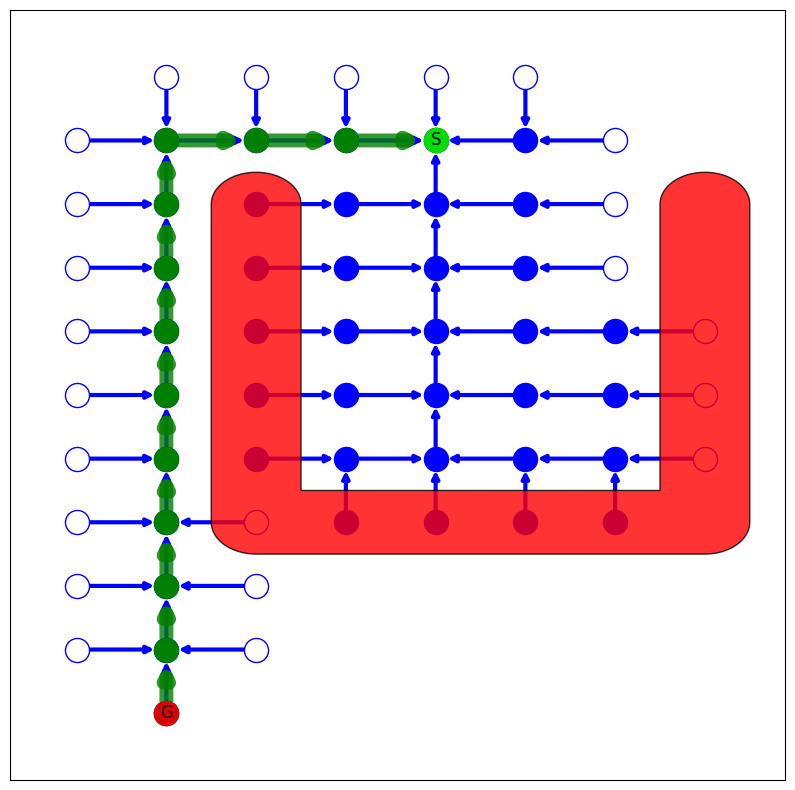

In [71]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
aStarVisualize(astar, solution, ax = ax)

Experiments
===========

* Change evaluation function to f(n) = w * h + (1-w) * g, and visualize results
* Implement another heuristic (e.g. Euklid) and make it switchable via a parameter.
